## Reproduction of the UniformatBridge model implementation

- This is an **_unofficial_** reproduction of the experiment described in "Transformer language model for mapping construction schedule activities to uniformat categories" by Yoonhwa Jung, Julia Hockenmaier, and Mani Golparvar-Fard, 2024.
- The study can be accessed at https://doi.org/10.1016/j.autcon.2023.105183.

In [1]:
!python -V

Python 3.11.6


In [2]:
# 6p: "Five epochs with a batch size of 32, a dropout rate of 0.1, and a learning rate of 1.5e−5 were used to fine-tune the model."
epoch_size = 5
batch_size = 32
dropout_rate = 0.1  # BertForSequenceClassification default dropout_rate = 0.1
learning_rate = 1.5e-5

rseed = 42  # 7p: "In Table 2 and 3, 𝜇 is the average performance on three random seeds, and 𝜎 is their standard deviation."

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Data

#### BIM and ASTM Uniformat categories

In [4]:
import pandas as pd

# Data should not be shared publicly.
df = pd.read_excel("E:/_datasets/jung_et_al_2024/0-overall-level3.xlsx", header=0)

cls = 'Level3'
df = df.loc[:, ['predwbs2', 'predwbs', 'predtask', 'wbs2', 'wbs', 'name', 'sucwbs2', 'sucwbs', 'suctask', cls]]

# df.iloc[0]

In [5]:
df['text'] = df.apply(
    lambda row: f"{row['predwbs2']} > {row['predwbs']} > {row['predtask']} [pred] {row['wbs2']} > {row['wbs']} > {row['name']} [succ] {row['sucwbs2']} > {row['sucwbs']} > {row['suctask']}",
    axis=1
)

print_idx = 6538  # 'Rain Water Drainage' case in Table 4
df['text'][print_idx]  # a sequence of schedule activities

'CONSTRUCTION SUPERSTRUCTURE > Roof > Set Mechanical Equipment [pred] CONSTRUCTION SUPERSTRUCTURE > Roof > Pipe Mechanical Equipment [succ]  100 KINGSHIGHWAY > COMMISSIONNG & INSPECTIONS > STARTUP'

In [6]:
df['label'] = df.apply(
    lambda row: f"[{row[cls]}]",
    axis=1
)

df['label'][print_idx]  # D2040: 'Rain Water Drainage' in ASTM Uniformat

'[D2040]'

In [7]:
from sklearn.model_selection import train_test_split

texts = df['text']
labels = df['label']

# 6p: "This dataset is further split into training, validation, and testing using a 60-20-20 distribution."
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.4, random_state=rseed)
validation_texts, test_texts, validation_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=rseed)

(len(train_texts), len(validation_texts), len(test_texts))

(20469, 6823, 6824)

#### ★ Additional Datasets: ASTM Uniformat II Classification for Building Elements Description
- https://www.govinfo.gov/content/pkg/GOVPUB-C13-5af96252bc88826c911daac93c449927/pdf/GOVPUB-C13-5af96252bc88826c911daac93c449927.pdf

In [8]:
import pandas as pd

# Publicly available definition of ASTM Uniformat II
df_astm = pd.read_excel("public_astm_uniformat_ii_classification.xlsx", header=0)

astm_texts = df_astm.apply(
    lambda row: f"[pred] {row['Level1']} {row['Level2']} {row['Level3']} [succ]",
    axis=1
)

astm_labels = df_astm.apply(
    lambda row: f"[{row['Class']}]",
    axis=1
)

print(astm_texts[:5])
print(astm_labels[:5])

0    [pred] SUBSTRUCTURE Foundations Standard Found...
1    [pred] SUBSTRUCTURE Foundations Special Founda...
2    [pred] SUBSTRUCTURE Foundations Slab on Grade ...
3    [pred] SHELL Superstructure Floor Construction...
4    [pred] SHELL Superstructure Roof Construction ...
dtype: object
0    [A1010]
1    [A1020]
2    [A1030]
3    [B1010]
4    [B1020]
dtype: object


### Tokenize

In [9]:
model_name = 'bert-base-uncased'

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

#### Tokenize a sequence of schedule activities

In [10]:
def encode(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

encode(df['text'][print_idx])['input_ids']

tensor([[  101,  2810, 28391,  1028,  4412,  1028,  2275,  6228,  3941,  1031,
          3653,  2094,  1033,  2810, 28391,  1028,  4412,  1028,  8667,  6228,
          3941,  1031, 10514,  9468,  1033,  2531,  5465,  4048,  5603,  4576,
          1028,  3222,  3070,  1004, 29589,  1028, 22752,   102]])

In [11]:
# Move to device
train_encodings = encode(train_texts.tolist()).to(device)
validation_encodings = encode(validation_texts.tolist()).to(device)
test_encodings = encode(test_texts.tolist()).to(device)

#### Tokenize target activity for classification

In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [13]:
import torch

# Move to device
train_labels_encoded = torch.tensor(encoded_labels[train_texts.index], dtype=torch.long).to(device)
validation_labels_encoded = torch.tensor(encoded_labels[validation_texts.index], dtype=torch.long).to(device)
test_labels_encoded = torch.tensor(encoded_labels[test_texts.index], dtype=torch.long).to(device)

In [14]:
from torch.utils.data import TensorDataset

# attention_mask is 1 for real tokens and 0 for padding tokens
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels_encoded)
validation_dataset = TensorDataset(validation_encodings['input_ids'], validation_encodings['attention_mask'], validation_labels_encoded)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels_encoded)

In [15]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Additional Tokenization for Additional Data

In [16]:
astm_encodings = encode(astm_texts.tolist()).to(device)
astm_labels_encoded = torch.tensor(encoded_labels[astm_texts.index], dtype=torch.long).to(device)
astm_dataset = TensorDataset(astm_encodings['input_ids'], astm_encodings['attention_mask'], astm_labels_encoded)
astm_loader = DataLoader(astm_dataset, batch_size=batch_size, shuffle=True)

### Model

In [17]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(set(encoded_labels)))
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1.5e-05
    maximize: False
    weight_decay: 0
)

#### ★ Additional fine-tuning with publicly available ASTM Uniformat II classification

100%|██████████| 200/200 [00:16<00:00, 11.92it/s]


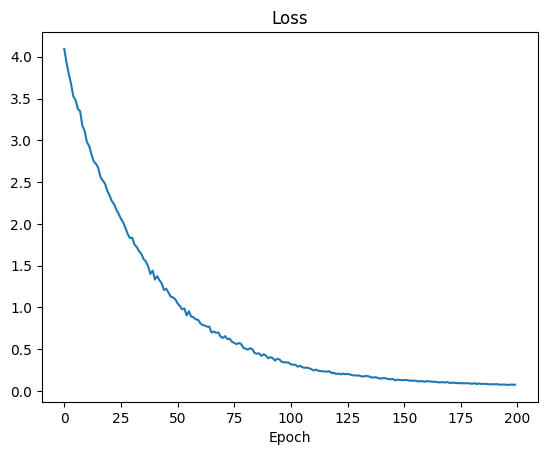

In [19]:
from tqdm import tqdm

losses = []
for epoch in tqdm(range(200)):
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in astm_loader:
        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    losses.append(total_loss / len(astm_loader))

import matplotlib.pyplot as plt
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

### Fine-tuning (Train & Validation)

100%|██████████| 640/640 [02:06<00:00,  5.05it/s]


Epoch 1 | Train Loss: 1.274820970511064 | Validation Loss: 0.3892607122798946


100%|██████████| 640/640 [01:59<00:00,  5.34it/s]


Epoch 2 | Train Loss: 0.26131154504255394 | Validation Loss: 0.17068802741156003


100%|██████████| 640/640 [01:59<00:00,  5.33it/s]


Epoch 3 | Train Loss: 0.12433907997619827 | Validation Loss: 0.09986843771048795


100%|██████████| 640/640 [01:59<00:00,  5.33it/s]


Epoch 4 | Train Loss: 0.07338083499635104 | Validation Loss: 0.07547599448012972


100%|██████████| 640/640 [02:00<00:00,  5.33it/s]


Epoch 5 | Train Loss: 0.05072399420896545 | Validation Loss: 0.06394961335974807


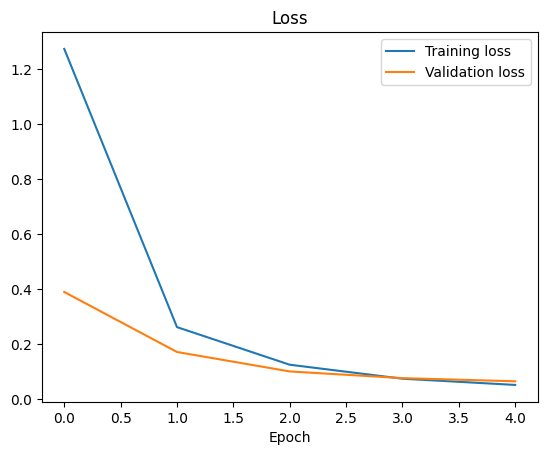

In [20]:
from tqdm import tqdm

train_losses = []
val_losses = []
for epoch in range(epoch_size):
    model.train()
    train_loss = 0
    for input_ids, attention_mask, labels in tqdm(train_loader):
        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for input_ids, attention_mask, labels in validation_loader:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            loss = outputs.loss
            val_loss += loss.item()
    val_losses.append(val_loss / len(validation_loader))
    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]} | Validation Loss: {val_losses[-1]}")

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

### Test

In [21]:
model.eval()
with torch.no_grad():
    true_labels = []
    predictions = []
    for input_ids, attention_mask, labels in test_loader:
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred_labels = torch.argmax(logits, dim=1)
        
        predictions.extend(pred_labels.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

### Experimental Results

#### Overall Results

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    true_labels, 
    predictions, 
    # average='weighted', 
    average='macro',  # Original paper setting (page 8)
    zero_division=0
)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.9856
Precision: 0.8950
Recall: 0.8925
F1 Score: 0.8925


#### Class-wise Results

In [23]:
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average=None, zero_division=0)

class_names = label_encoder.inverse_transform(list(set(true_labels)))

performance_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})
performance_df.to_csv(f'experimental_results_rseed{rseed}_with_definition.csv')
performance_df

,Class,Precision,Recall,F1 Score
0,[A1010],1.000000,0.970149,0.984848
1,[A1020],1.000000,0.983607,0.991736
2,[A1030],0.946667,1.000000,0.972603
3,[A2010],0.961039,1.000000,0.980132
4,[A2020],0.916667,0.846154,0.880000
5,[B1010],0.997018,0.996028,0.996523
6,[B1020],0.992000,0.946565,0.968750
7,[B2010],0.998192,0.998192,0.998192
8,[B2020],1.000000,1.000000,1.000000
9,[B2030],1.000000,0.933333,0.965517
